#Brain Anomaly Detection

Morariu Tudor

Import librariile necesare pentru citirea datelor.

In [1]:
from PIL import Image
import glob
import pandas as pd
from time import gmtime, strftime

In [2]:
def watermark():
  return "Tudor Morariu, generated at: " + strftime("%H:%M:%S", gmtime());

Citirea datelor.

In [3]:
image_dir = "./data/data";
images = glob.glob(image_dir + "/*.png");

labels = pd.read_csv('./data/train_labels.txt');

In [4]:
# Reduc dimensiunea datelor pentru testare mai rapida
images = images[:753];
labels = labels[:753];

Plotam distributia claselor.

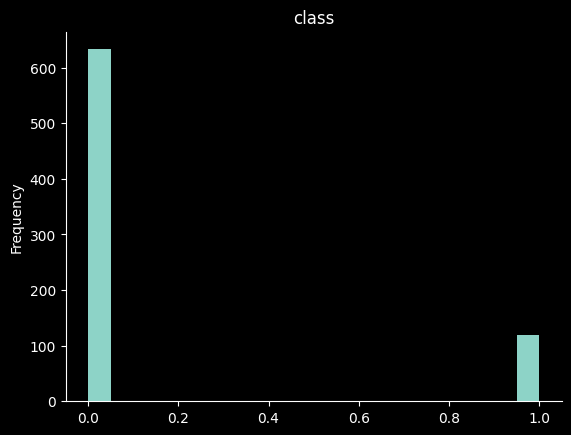

In [5]:
from matplotlib import pyplot as plt
import matplotlib as mpl

# Folosesc un backround negru pentru lizibilitate mai buna
plt.style.use('dark_background')


labels['class'].plot(kind='hist', bins=20, title='class')
plt.gca().spines[['top', 'right',]].set_visible(False)

Afisam cateva imagini pentru a vedea dataset-ul

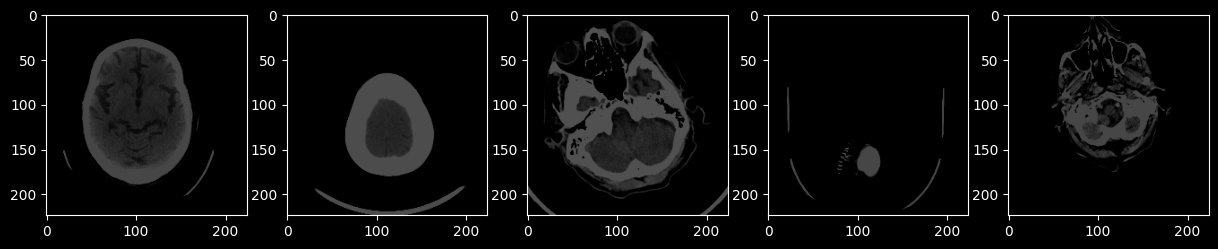

In [6]:
import matplotlib.pyplot as plt

f, pl = plt.subplots(1, 5);

f.set_figheight(15)
f.set_figwidth(15)

for i in range(5):
  im = Image.open(images[i]);
  pl[i].imshow(im);

plt.show();

1.   Obs: Rezolutia Imaginilor este constanta
2.   Obs: Imaginile sunt in format grayscale
3.   Obs: Ni se dau multiple "straturi" din scan-ul CT

!!! Optional feature --> Canny edge detection

Tranformam din imagini in array-uri de numere.

In [7]:
import numpy as np

array_images = np.array([]);

for i in range(len(images)):
  image = Image.open(images[i]);

  array_image = np.array(image);
  array_images = np.append(array_images, array_image);

*    Obs: Procesul dureaza mult pentru tot dataset-ul







In [8]:
# Reshape array-ul de imagini pentru a avea o structura de tipul (nr_imagini, nr_pixeli_verticali, nr_pixeli_orizontali, nr_pixeli_culoare)
array_images = array_images.reshape((-1, 224, 224, 3));

In [9]:
print(array_images.shape);

(753, 224, 224, 3)


Pntru inceput voi alege feature-urile pixeli efectivi fara nici un fel de procesare.

Voi face o matrice in care fiecare linie e o imagine.

In [10]:
list_features = array_images.reshape((len(array_images), -1));
list_labels = labels['class'];

#print(list_features.shape)

In [11]:
from sklearn.model_selection import train_test_split

train_features, test_features, train_labels, test_labels = train_test_split(list_features, list_labels, test_size=0.3);

In [12]:
print(train_labels.shape)

(527,)


In [13]:
train_features = train_features.reshape((-1, 224, 224, 3));
test_features = test_features.reshape((-1, 224, 224, 3));
#train_labels = train_labels.reshape((-1));
#test_labels = test_labels.reshape((-1, 224, 224, 3));

print(train_features.shape)

(527, 224, 224, 3)


In [14]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Activation, Dense, Conv2D, MaxPool2D, Dropout, Flatten, LeakyReLU
import keras
from keras import layers

/Users/tudor/Documents/Work AI/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [15]:
Model = Sequential()

# Adaug un strat de convolutie pentru a evidentia diferentele minore intre pixeli
Model.add(Conv2D(32, (3,3), padding = 'same', input_shape=train_features.shape[1:]))
Model.add(Activation('relu'))
Model.add(MaxPool2D(pool_size=(2,2)))

Model.add(Flatten())

# Adaug inca 4 straturi de neuroni conectati intre ei
# Pe primele trei straturi aplicam functia de activare RElU pentru a pastra cat mai multa informatie
# Pe unltimul strat aplicam Sigmoid pentru a obtine un rezultat intre 0 si 1

Model.add(Dense(256))
Model.add(Activation('relu'))

Model.add(Dense(64))
Model.add(Activation('relu'))

Model.add(Dense(32))
Model.add(Activation('relu'))

Model.add(Dense(1))
Model.add(Activation('sigmoid'))


Model.compile(loss = 'binary_crossentropy', optimizer = 'RMSprop', metrics=['accuracy'])

/Users/tudor/Documents/Work AI/.venv/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2024-06-18 22:45:46.469589: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2024-06-18 22:45:46.469621: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-06-18 22:45:46.469627: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-06-18 22:45:46.469676: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-06-18 22:45:46.469696: I tensorflow/core/common_runtime/pluggable_device/pluggable_dev

In [16]:
# Invatam modelul si pastram istoricul loss-ului si acuratetii
History = Model.fit(train_features, train_labels, batch_size = 64, epochs = 100, validation_split = 0.1, verbose = 1);

Epoch 1/100


2024-06-18 22:45:48.007948: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 382ms/step - accuracy: 0.6003 - loss: 714.3558 - val_accuracy: 0.7547 - val_loss: 709.5470
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 171ms/step - accuracy: 0.8077 - loss: 316.5008 - val_accuracy: 0.7547 - val_loss: 147.1656
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 166ms/step - accuracy: 0.7370 - loss: 101.0501 - val_accuracy: 0.7547 - val_loss: 77.9434
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 169ms/step - accuracy: 0.7414 - loss: 57.0986 - val_accuracy: 0.2830 - val_loss: 47.3754
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 169ms/step - accuracy: 0.7292 - loss: 42.3060 - val_accuracy: 0.3019 - val_loss: 51.8445
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 167ms/step - accuracy: 0.7155 - loss: 32.1213 - val_accuracy: 0.7170 - val_loss: 16.2833
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 166ms/step - accuracy: 0.9902 - loss: 0.2204 - val_accuracy: 0.7170 - val_loss: 16.3323
Epoch 8/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 166ms/step - accuracy: 0.9864 - loss: 0.0967 - val_accuracy: 0.71

In [17]:
#Luam datele din invatarea modelului

acc = History.history['accuracy']
val_acc = History.history['val_accuracy']

loss = History.history['loss']
val_loss = History.history['val_loss']

epochs = range(1, len(acc) + 1)

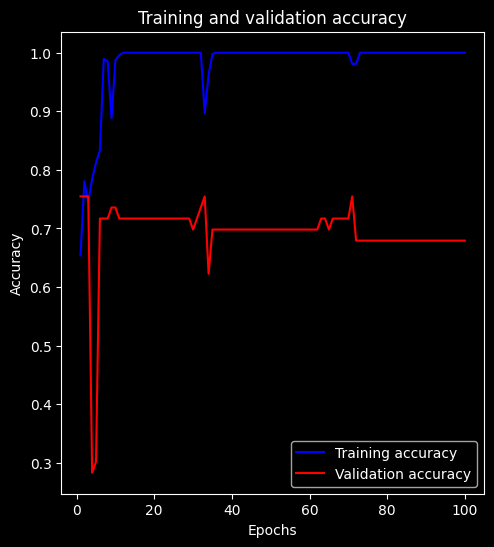

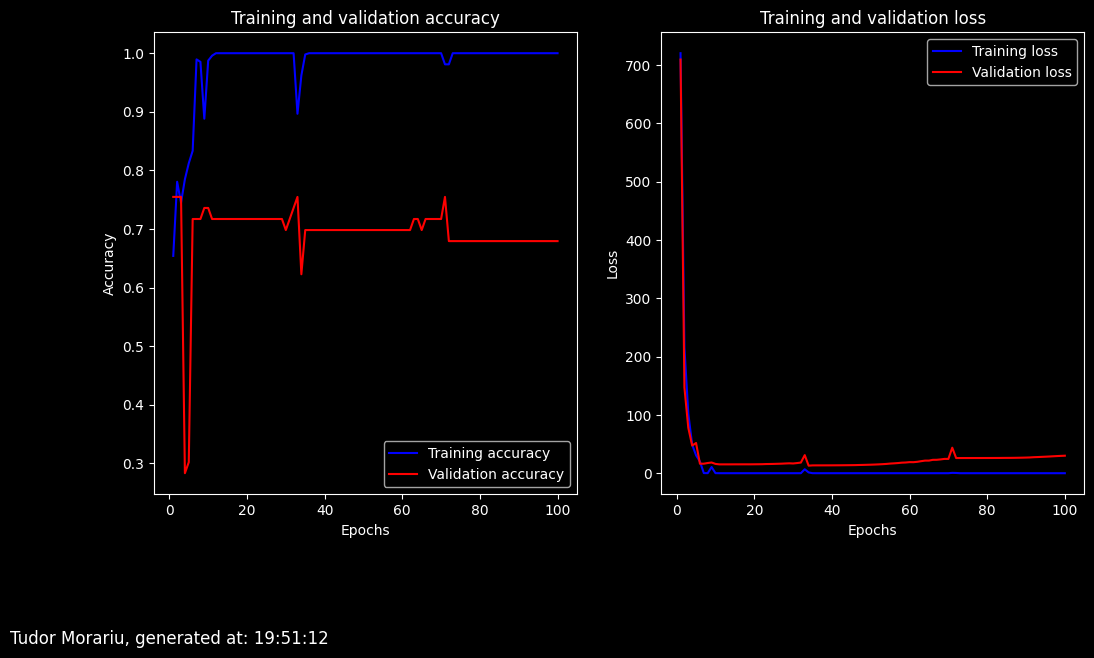

In [32]:
# Plotam acuratetea modelului in funtie de epoca
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)

plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')

plt.title('Training and validation accuracy')

plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.legend()

# Adaugam un watermank jmecher
plt.text(0, 0, watermark(), fontsize=12, color="white", ha="center", va="center", alpha=1, rotation=0)

# Plotam loss-ul modelului in functie de epoca
plt.subplot(1, 2, 2)

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')

plt.title('Training and validation loss')

plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.legend()

